In [2]:
#Do install apoc and graphdatascience packages in neo4j and neo4j, py2neo and matplotlib before running this notebook
#and set apoc.export.file.enabled=true in your apoc.conf
#importing required packages

from neo4j import GraphDatabase
from py2neo import Graph
from py2neo.data import Node, Relationship
import pandas as pd

In [3]:
#creating driver to connect to Neo4j
url = "bolt://localhost:7687"
username = "neo4j"
password = "anujbansal"

driver = GraphDatabase.driver(url, auth = (username,password))

In [4]:
#function to run cypher queries
def run_cypher_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.data()

For our usecase we are using the North Carolina 5 million data, provided by "Database Group Leipzig" for Entity Resolution Benchmarking at the following link:
https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution
Dataset charaterstics:\
A. 5 Sources each having voters' data like - name, surname, subrub and pincode\
B. For our use case we are using the 20,000 records from each source i.e. 100,000 records in total\
C. Each source is duplicate free but shares duplicates from other sources with the synthetically corrupted entity data\
D. Out of 100000 records, 75217(~75%) records are unique entities and 24783 (25%) records are duplicate records\

In [5]:
#EDA in Python
input_csv_path = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv"
df = pd.read_csv(input_csv_path, nrows = 20000)
df["source"]= 0
input_csv_path1 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv"
df1 = pd.read_csv(input_csv_path1, nrows = 20000)
df1["source"]= 1
input_csv_path2 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv"
df2 = pd.read_csv(input_csv_path2, nrows = 20000)
df2["source"]= 2
input_csv_path3 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv"
df3 = pd.read_csv(input_csv_path3, nrows = 20000)
df3["source"]= 3
input_csv_path4 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv"
df4 = pd.read_csv(input_csv_path4, nrows = 20000)
df4["source"]= 4

# List of DataFrames
dfs = [df,df1, df2, df3, df4]
# Concatenate the DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
print(df_combined.head())
print(df_combined[df_combined["recid"].isin([878723,101994])].sort_values(by=['recid']))

     recid givenname   surname         suburb postcode  source
0  7852009   kadelyn  gragnani         waxhaw    28|73       0
1  3138435     ronel    carter     washington    2788g       0
2  6117295     jason   roehrig  millers ceeek    286s1       0
3  6401695    antrea      mure     greensboro    27410       0
4  5202204    caedar    oliver   jacksonville    28542       0
        recid givenname      surname        suburb postcode  source
5168   101994     norma  strawl>erry     high poit    27260       0
25214  101994     norma   strawberry    high piont    27210       1
45203  101994      norm   strawberry    high poknt    27260       2
65214  101994     norma   strawbe5ry    high ppint    27260       3
85237  101994     norma   strawbe5ry    hihh point    27260       4
19660  878723   edwarzd       brooks  fayetteviile    28304       0
39656  878723    edward       brookd  fayetteville    283o4       1
59732  878723   edwarcl       brooks   fayettevile    28304       2
79777  878

In [38]:
print(df_combined["source"].value_counts())
print("\n Number of duplicate values in 'recid' column:", df_combined["recid"].duplicated().sum())
print("\n Number of unique values in 'recid' column:", df_combined["recid"].nunique())
print("\n Number of unique values in 'recid' column in source categories:", df_combined.groupby("source")["recid"].nunique())


source
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64

 Number of duplicate values in 'recid' column: 24783

 Number of unique values in 'recid' column: 75217

 Number of unique values in 'recid' column in source categories: source
0    20000
1    20000
2    20000
3    20000
4    20000
Name: recid, dtype: int64


In [6]:
print(df_combined.isnull().sum())

recid         0
givenname    15
surname       2
suburb        3
postcode      6
source        0
dtype: int64


In [13]:
#cleaning the cypher database

query = """
    Match(n) Detach Delete n;
"""
results = run_cypher_query(query)

Each of the source file is getting loaded and cleaned in Neo4j database. Along with loading and cleaning, each record is used to create a node and attributes such as surname, givennamem suburb and postcode are used to create node properites after data cleaning (removal of special characters, changing of case, removal of digits from names etc.). In addition few more properties are derived:
1. Source : SourceKey to identify the source from which record is being loaded
2. MatchKey: Prefix of size 2 of surname
3. MatchKey2: prefie of size of 2 of givenname
4. MatchKey3: prefie of size of 2 of suburb
5. MatchKey4: prefie of size of 3 of Postcode

Here is a snapshot of data after these steps:
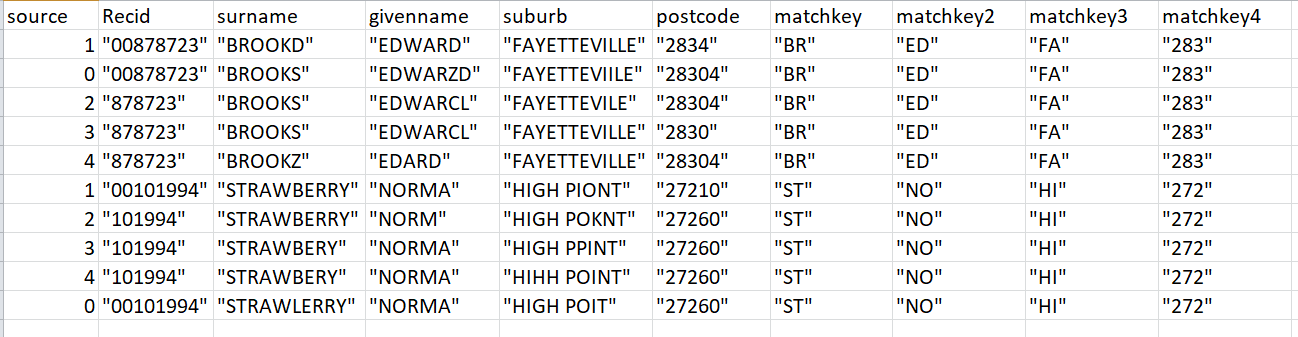

In [14]:
#Loading and cleaning the data file 0 in neo4j

query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 0,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.matchkey3 = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.matchkey4 = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
results = run_cypher_query(query)


In [15]:
#Loading the data file 1 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 1,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.matchkey3 = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.matchkey4 = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.21 s


In [16]:
#Loading the data file 2 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 2,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.matchkey3 = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.matchkey4 = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.2 s


In [17]:
#Loading the data file 3 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 3,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.matchkey3 = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.matchkey4 = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.7 s


In [18]:
#Loading the data file 4 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 4,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.matchkey3 = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.matchkey4 = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.25 s


In [19]:
query1 = """CREATE INDEX node_range_source FOR (n:Recid) ON (n.source) ;"""
query2 = """CREATE INDEX node_range_matchkey FOR (n:Recid) ON (n.matchkey) ;"""
query3 = """CREATE INDEX node_range_matchkey2 FOR (n:Recid) ON (n.matchkey2); """
query4 = """CREATE INDEX node_range_matchkey3 FOR (n:Recid) ON (n.matchkey3); """
query5 = """CREATE INDEX node_range_matchkey4 FOR (n:Recid) ON (n.matchkey4); """
%time results = run_cypher_query(query1)
%time results = run_cypher_query(query2)
%time results = run_cypher_query(query3)
%time results = run_cypher_query(query4)
%time results = run_cypher_query(query5)

CPU times: total: 0 ns
Wall time: 101 ms
CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 15.6 ms
Wall time: 26.8 ms
CPU times: total: 0 ns
Wall time: 10.9 ms
CPU times: total: 0 ns
Wall time: 12.7 ms


Here is an example of a sub-graph of few nodes:
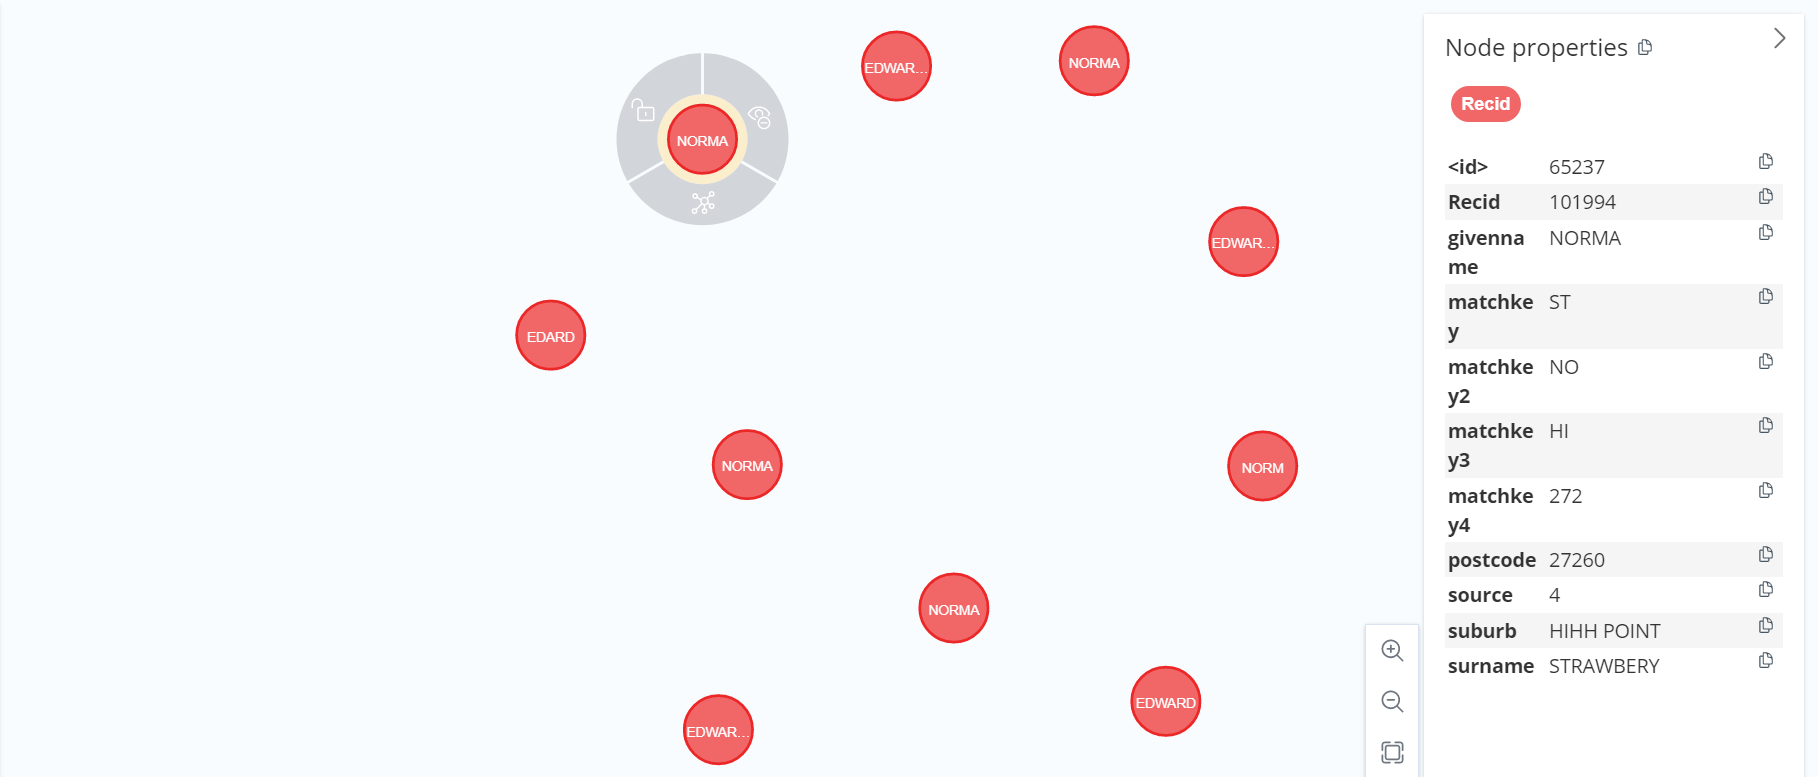

# Workflow

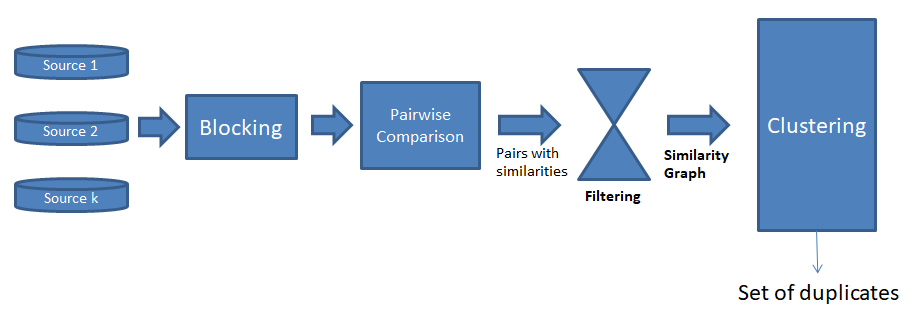

# Data Input
Multiple distinct data sources contain the entities to be matched and grouped. It's worth noting that all sources have been ensured to be free of duplicates.
The blocking process, Pairwise Comparison and Filtering process are executed in four mutually exclusive concurrent phases for improved efficiency:

1. **Phase A:**  Different Source, Same initial prefix of surname, same initial prefix of suburb
2. **Phase B:**  Different Source, Different initial prefix of surname, same initial prefix of givenname, same initial prefix of suburb
3. **Phase C:**  Different Source, Different initial prefix of suburb, Same initial prefix of surname, same initial prefix of postcode
4. **Phase D:**  Different Source, Different initial prefix of suburb, Different initial prefix of surname, same initial prefix of postcode, same initial prefix of givenname



# Blocking Strategy
To optimize the comparison process and minimize redundant computations, a blocking approach is employed. Instead of naively comparing each entity from one data source against all entities from another source, the entities are divided into groups or "blocks" using predefined attributes. This ensures that only entities with identical blocking attributes need to be coed.mpar

# Pairwise Comparison
Within each block originating from any input data source, all entities undergo pairwise comparison. The similarity of attribute for each pair is captured through similarity scores.

# Filtering Process
To determine pairs that are likely matches, a filtering step is introduced. This involves applying predetermined threshold values (established through multiple iterations) to the similarity scores. Pairs with similarity scores exceeding these thresholds are identified.

# Similarity Graph Construction
For the pairs that pass through the filtering stage, a similarity graph is constructed. Edges between vertices are c reated, with the similarity scores serving as the properties of these edges.

# Clustering Phase
This step focuses on the aggregation of related vertices within the similarity graph. Vertices that aareegrouped together usingeir properties..
s syr.e..



In [22]:
phaseA = """
   //Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.matchkey = b.matchkey and a.matchkey3 = b.matchkey3

//calculating similarities using jaroWinklerDistance
WITH *, toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim1,
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim2,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim3,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim4
//filetring based on threshold
WHERE sim1> 85 and sim2>85 and sim3>65 and sim4>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim1:sim1,sim2:sim2,sim3:sim3,sim4:sim4}]-(b)
"""

phaseB =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.matchkey <> b.matchkey and a.matchkey2 = b.matchkey2 and  a.matchkey3 = b.matchkey3

//calculating similarities using jaroWinklerDistance
WITH *, toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim1,
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim2,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim3,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim4
//filetring based on threshold
WHERE sim1> 85 and sim2>85 and sim3>65 and sim4>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim1:sim1,sim2:sim2,sim3:sim3,sim4:sim4}]-(b)
"""

phaseC =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.matchkey = b.matchkey and  a.matchkey3 <> b.matchkey3 and a.matchkey4 = b.matchkey4

//calculating similarities using jaroWinklerDistance
WITH *, toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim1,
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim2,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim3,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim4
//filetring based on threshold
WHERE sim1> 85 and sim2>85 and sim3>65 and sim4>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim1:sim1,sim2:sim2,sim3:sim3,sim4:sim4}]-(b)
"""

phaseD =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.matchkey <> b.matchkey and a.matchkey2 = b.matchkey2 and  a.matchkey3 <> b.matchkey3 and a.matchkey4 = b.matchkey4

//calculating similarities using jaroWinklerDistance
WITH *, toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim1,
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim2,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim3,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim4
//filetring based on threshold
WHERE sim1> 85 and sim2>85 and sim3>65 and sim4>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim1:sim1,sim2:sim2,sim3:sim3,sim4:sim4}]-(b)
"""



In [23]:

def main():
    with GraphDatabase.driver(url, auth = (username,password)) as driver:
        similarity_scores(driver)

def similarity_scores(driver):
   

    # Session a
    with driver.session(database="neo4j") as session_a:
        session_a.run(phaseA) 

    # Session b
    with driver.session(database="neo4j") as session_b:
        session_b.run(phaseB)

    # Session c
    with driver.session(database="neo4j") as session_c:
        session_c.run(phaseC) 

    # Session d
    with driver.session(database="neo4j") as session_d:
        session_d.run(phaseD)

if __name__ == "__main__":
    %time main()
    



CPU times: total: 0 ns
Wall time: 6min 11s


After blocking, similarity score calculations and filerting, selected pairs of entities are linked together with similarity scores forming the property of edges
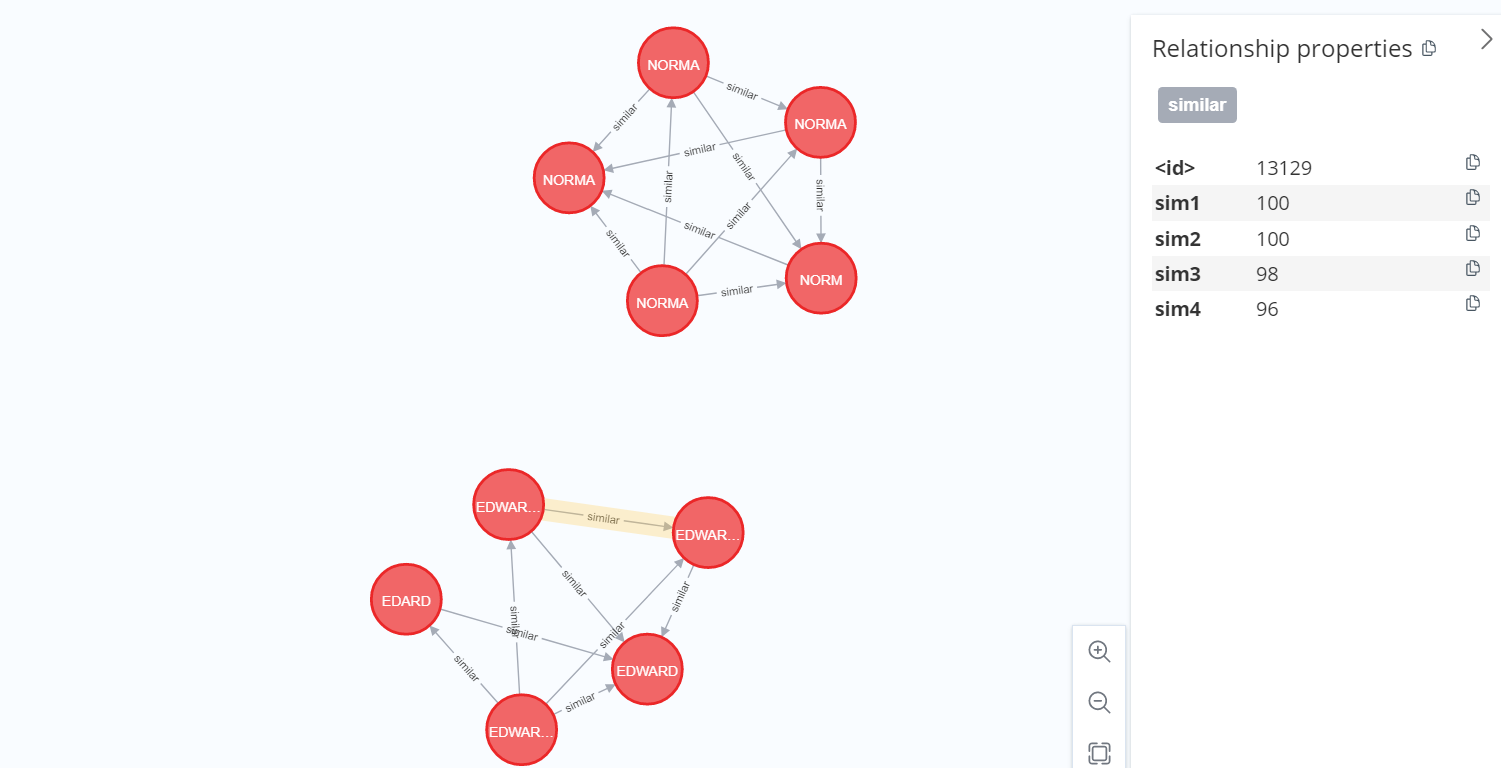

In [24]:
query ="""CALL gds.graph.drop('mygraph2', false) YIELD graphName;"""
%time results = run_cypher_query(query)

CPU times: total: 15.6 ms
Wall time: 104 ms


In [25]:
#graph creation in neo4j
query = """
CALL gds.graph.project(
	'mygraph2',
	'Recid',
	{
	similar:{
	orientation:'UNDIRECTED',
	properties:['sim1','sim2','sim3','sim4']
	}
	}
)
"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 4.28 s


In [26]:
#entity resolution in neo4j
query = """
CALL gds.labelPropagation.write('mygraph2', { writeProperty: 'community' }) YIELD communityCount, ranIterations, didConverge
"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 2.22 s


Here is an example how communities are assigned to entities similar to each other:

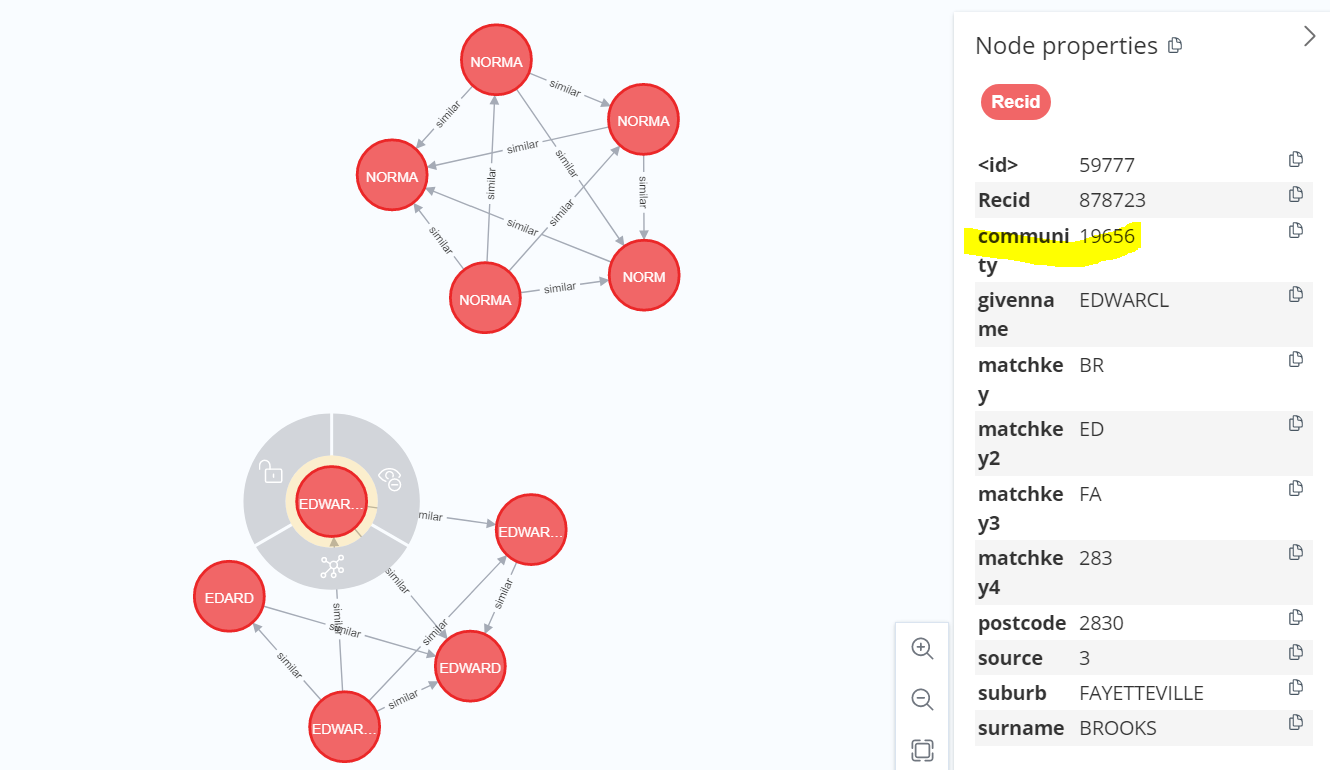

Highlighted properties of another node in same cluster:

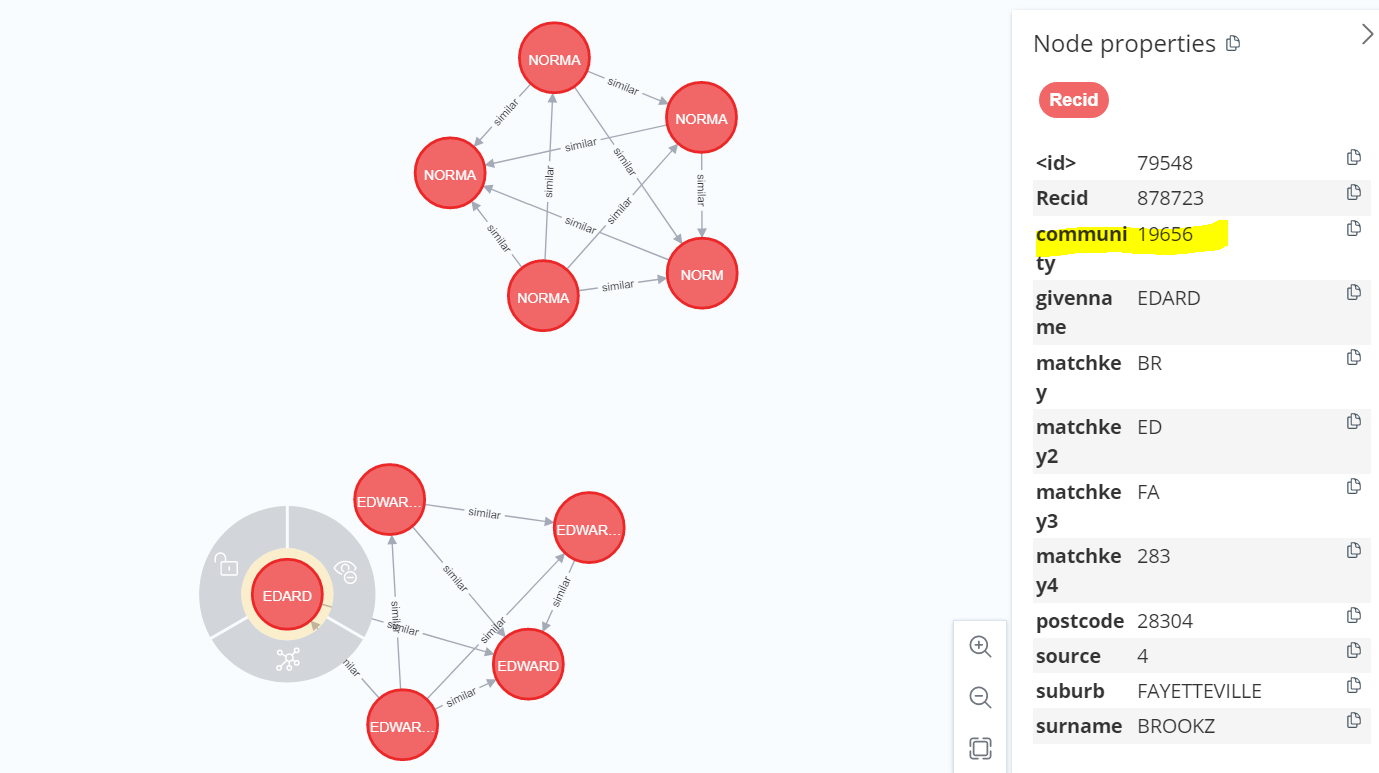

Here is how the data look like when exported in a csv format, Community id is a model generated id identifying the set of duplicate entities:
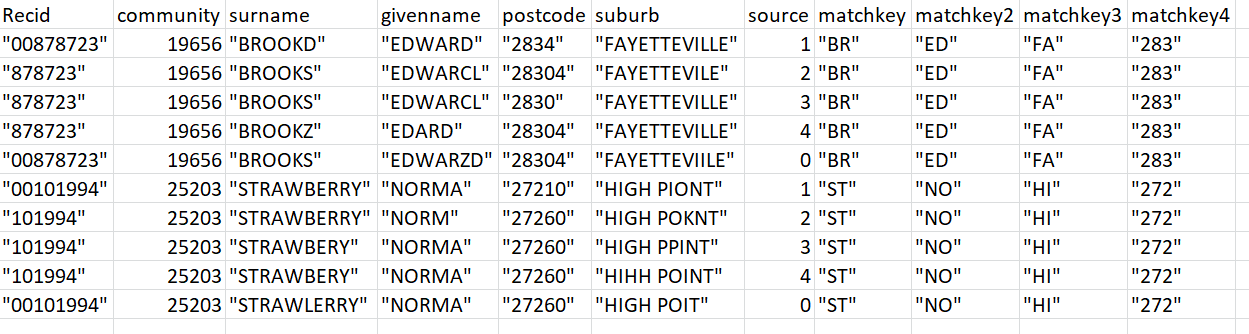

In [75]:
#exporting the output
query ="""
call apoc.export.csv.query("Match(n) Return n.Recid as Recid, n.community as community, n.surname as surname, n.givenname as givenname,n.postcode as postcode,n.suburb as suburb,n.source as source,n.matchkey as matchkey,n.matchkey2 as matchkey2,n.matchkey3 as matchkey3,n.matchkey4 as matchkey4","export12.csv",{})
"""
results = run_cypher_query(query)

In [28]:
driver.close()

In [27]:
csv_path = r"C:\Users\lenovo\Downloads\export12.csv"
df = pd.read_csv(csv_path)
print(df.head)

<bound method NDFrame.head of             Recid  community       surname    givenname postcode  \
0      "04194454"          0       "BATTS"     "ASHLEV"   "2766"   
1      "04263711"          1       "PEREZ"    "TIFFAMY"  "28354"   
2      "08089896"          2       "MURRY"      "DAVID"  "28268"   
3      "07879554"          3  "HUTCHINSON"    "SHAMKEA"   "2784"   
4      "04338459"          4      "SNYDDR"       "JOHN"   "2749"   
...           ...        ...           ...          ...      ...   
99995  "01997484"      99995      "AUSLEY"       "GIAN"  "27522"   
99996  "02303067"      99996   "HENDRICKS"    "CARLENE"  "28741"   
99997  "04528478"      99997     "FLEMING"  "SETPHANIE"  "27834"   
99998  "05838706"      99998    "TEAHRELL"      "DUNAE"  "27278"   
99999  "06091763"      99999       "APPLE"      "KADIE"   "2843"   

               suburb  source matchkey matchkey2 matchkey3 matchkey4  
0           "RALEIGH"       1     "BA"      "AS"      "RA"     "276"  
1          

In [29]:
df['Recid'] =pd.to_numeric(df['Recid'].str.replace('"',''))
print(df.head)

<bound method NDFrame.head of          Recid  community       surname    givenname postcode          suburb  \
0      4194454          0       "BATTS"     "ASHLEV"   "2766"       "RALEIGH"   
1      4263711          1       "PEREZ"    "TIFFAMY"  "28354"          "VASS"   
2      8089896          2       "MURRY"      "DAVID"  "28268"     "CHARLOGTE"   
3      7879554          3  "HUTCHINSON"    "SHAMKEA"   "2784"   "ROCKY MOUNT"   
4      4338459          4      "SNYDDR"       "JOHN"   "2749"     "LOUISBURG"   
...        ...        ...           ...          ...      ...             ...   
99995  1997484      99995      "AUSLEY"       "GIAN"  "27522"     "CREEDNOOR"   
99996  2303067      99996   "HENDRICKS"    "CARLENE"  "28741"     "HIGHLANDW"   
99997  4528478      99997     "FLEMING"  "SETPHANIE"  "27834"    "GREENVILLW"   
99998  5838706      99998    "TEAHRELL"      "DUNAE"  "27278"  "HILLSBOROUGH"   
99999  6091763      99999       "APPLE"      "KADIE"   "2843"    "WILMINGTON"  

In [30]:
df = df.sort_values(by=['Recid', 'community'])
df['community_wRecid_Primary'] = df.groupby('Recid')['community'].shift(1)
df['False_Negative_Flag'] = df.apply(lambda row: 0 if pd.isna(row['community_wRecid_Primary']) else (0 if row['community_wRecid_Primary'] == row['community'] else 1), axis=1)
df = df.sort_values(by=['Recid', 'community'])
df['Recid_wcommunity_Primary'] = df.groupby('community')['Recid'].shift(1)
df['False_Positive_Flag'] = df.apply(lambda row: 0 if pd.isna(row['Recid_wcommunity_Primary']) else (0 if row['Recid_wcommunity_Primary'] == row['Recid'] else 1), axis=1)


print(df[df['Recid']==2073])
print("False Negatives:" , df['False_Negative_Flag'].sum())
print("False Positives:" , df['False_Positive_Flag'].sum())

       Recid  community   surname givenname postcode         suburb  source  \
11081   2073      11081  "DAYLOR"  "JARIET"  "27869"  "RICH SQUARE"       1   
51107   2073      51107  "TAYLOR"   "JANED"   "2786"  "RICH SQUARE"       3   

      matchkey matchkey2 matchkey3 matchkey4  community_wRecid_Primary  \
11081     "DA"      "JA"      "RI"     "278"                       NaN   
51107     "TA"      "JA"      "RI"     "278"                   11081.0   

       False_Negative_Flag  Recid_wcommunity_Primary  False_Positive_Flag  
11081                    0                       NaN                    0  
51107                    1                       NaN                    0  
False Negatives: 5552
False Positives: 368


Out of 24783 actual duplicate records, model is correctly able to identify 19231 (~77.6%) duplicate records. And 368 records identified as duplicates by model are false positives with a false positive rate of 1.7%. End to End runtime for 100,000 records is around ~6.5 minutes.
